In this notebook, we will see a very simple example of how a Simple RNN can be built and applied, what is the format of the input/output data and the parameters. Then, we will apply a LSTM to a many-to-one and a many-to-many text examples

Import libraries and supporting function to round numbers

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
def round_tf(tensor, decimals=0):
   
    """Auxiliary function to round numbers
    in tensorflow/keras"""
    
    multiplier = tf.constant(10**decimals, dtype=tensor.dtype)
    return tf.round(tensor * multiplier) / multiplier

### 1. Simple RNN
The example below shows how to define a Simple RNN with Keras and apply it to a dummy dataset of randomly generated data

#### Defining the dimensionality of our problem: input data
Dimensionality of our problem: In NNs in general it is very important to properly understand the dimensionality of our inputs/outputs in order to properly define our network architecture  
In this case, we are going to generate a sample data of one observation of five steps (in the text analogy these would be sentences of five words, in the time series case it would be series of five datapoints, etc). In each step we would have a vector of three dimensions (going back to the example of a ball trajectory, it could be the x, y, z position of the ball at each time step)

In [3]:
number_of_sequences = 1        # number of observations (e.g., number of balls)
sequence_length = 5            # number of steps (e.g, number of time frames for which we recorded the ball position)
vector_length_in_each_step = 3 # dimension of each of the steps (e.g., x, y, z position of the ball)

Here we will generate a tensor of random data with the above dimensionality. Note that in general the process is the other way around (we have the data first and from that and the information of our problem we define what the dimensionality is)

In [4]:
tf.random.set_seed(42)
# generate data with the mentioned dimensions
sample_data = tf.random.uniform(shape=(number_of_sequences, 
                                       sequence_length, 
                                       vector_length_in_each_step)
                               )
# Round decimals
sample_data = round_tf(sample_data, 2)

print(sample_data.numpy())
print()
print(sample_data.shape)

[[[0.66 0.44 0.35]
  [0.46 0.03 0.68]
  [0.74 0.87 0.23]
  [0.22 0.31 0.72]
  [0.13 0.55 0.57]]]

(1, 5, 3)


#### Defining the dimensionality of our problem: RNN
As it happens with other types of NNs, in Keras, we can easily define our RNN by the keras layers functionality. In this case we will define a simple RNN layer  
By default, SimpleRNN uses *tanh* as activation function (this is why we don't explicitly define it here). You can check the specific parameters in the keras documentation https://keras.io/api/layers/recurrent_layers/simple_rnn/

In this case, we will define our RNN to have an output of two units, and to return the predictions at each step

It is suggested to the reader to play a bit with the *units* and *return_sequences* parameters and see how the output of the layer changes

In [5]:
rnn_layer = keras.layers.SimpleRNN(units=2, 
                                   return_sequences=True,
                                   # the NN is randomly initialized
                                   kernel_initializer=keras.initializers.GlorotUniform(seed=42),
                                   recurrent_initializer=keras.initializers.orthogonal(seed=42)
                                  )

We can directly apply our RNN to our data (note that this is a very simple example to see how it works, since we haven't even trained the RNN. We are just seeing how to define a RNN and apply it to a sequence of data

In [6]:
output = rnn_layer(sample_data)
# We round decimals:
output = round_tf(output, 2)

print(output.numpy())
print()
print(output.shape)

[[[-0.41 -0.35]
  [-0.85  0.46]
  [ 0.18  0.05]
  [-0.5  -0.28]
  [-0.59  0.03]]]

(1, 5, 2)


As observed, in this case the layer returns an output at each step of size two

### 2. An example with text data
We are going to see now an example with text data, in which we will use a slightly more complicated RNN: the LSTM, and an Embedding layer to process our text data. See the example below that represents a many-to-one architecture

<img width=300 src=" 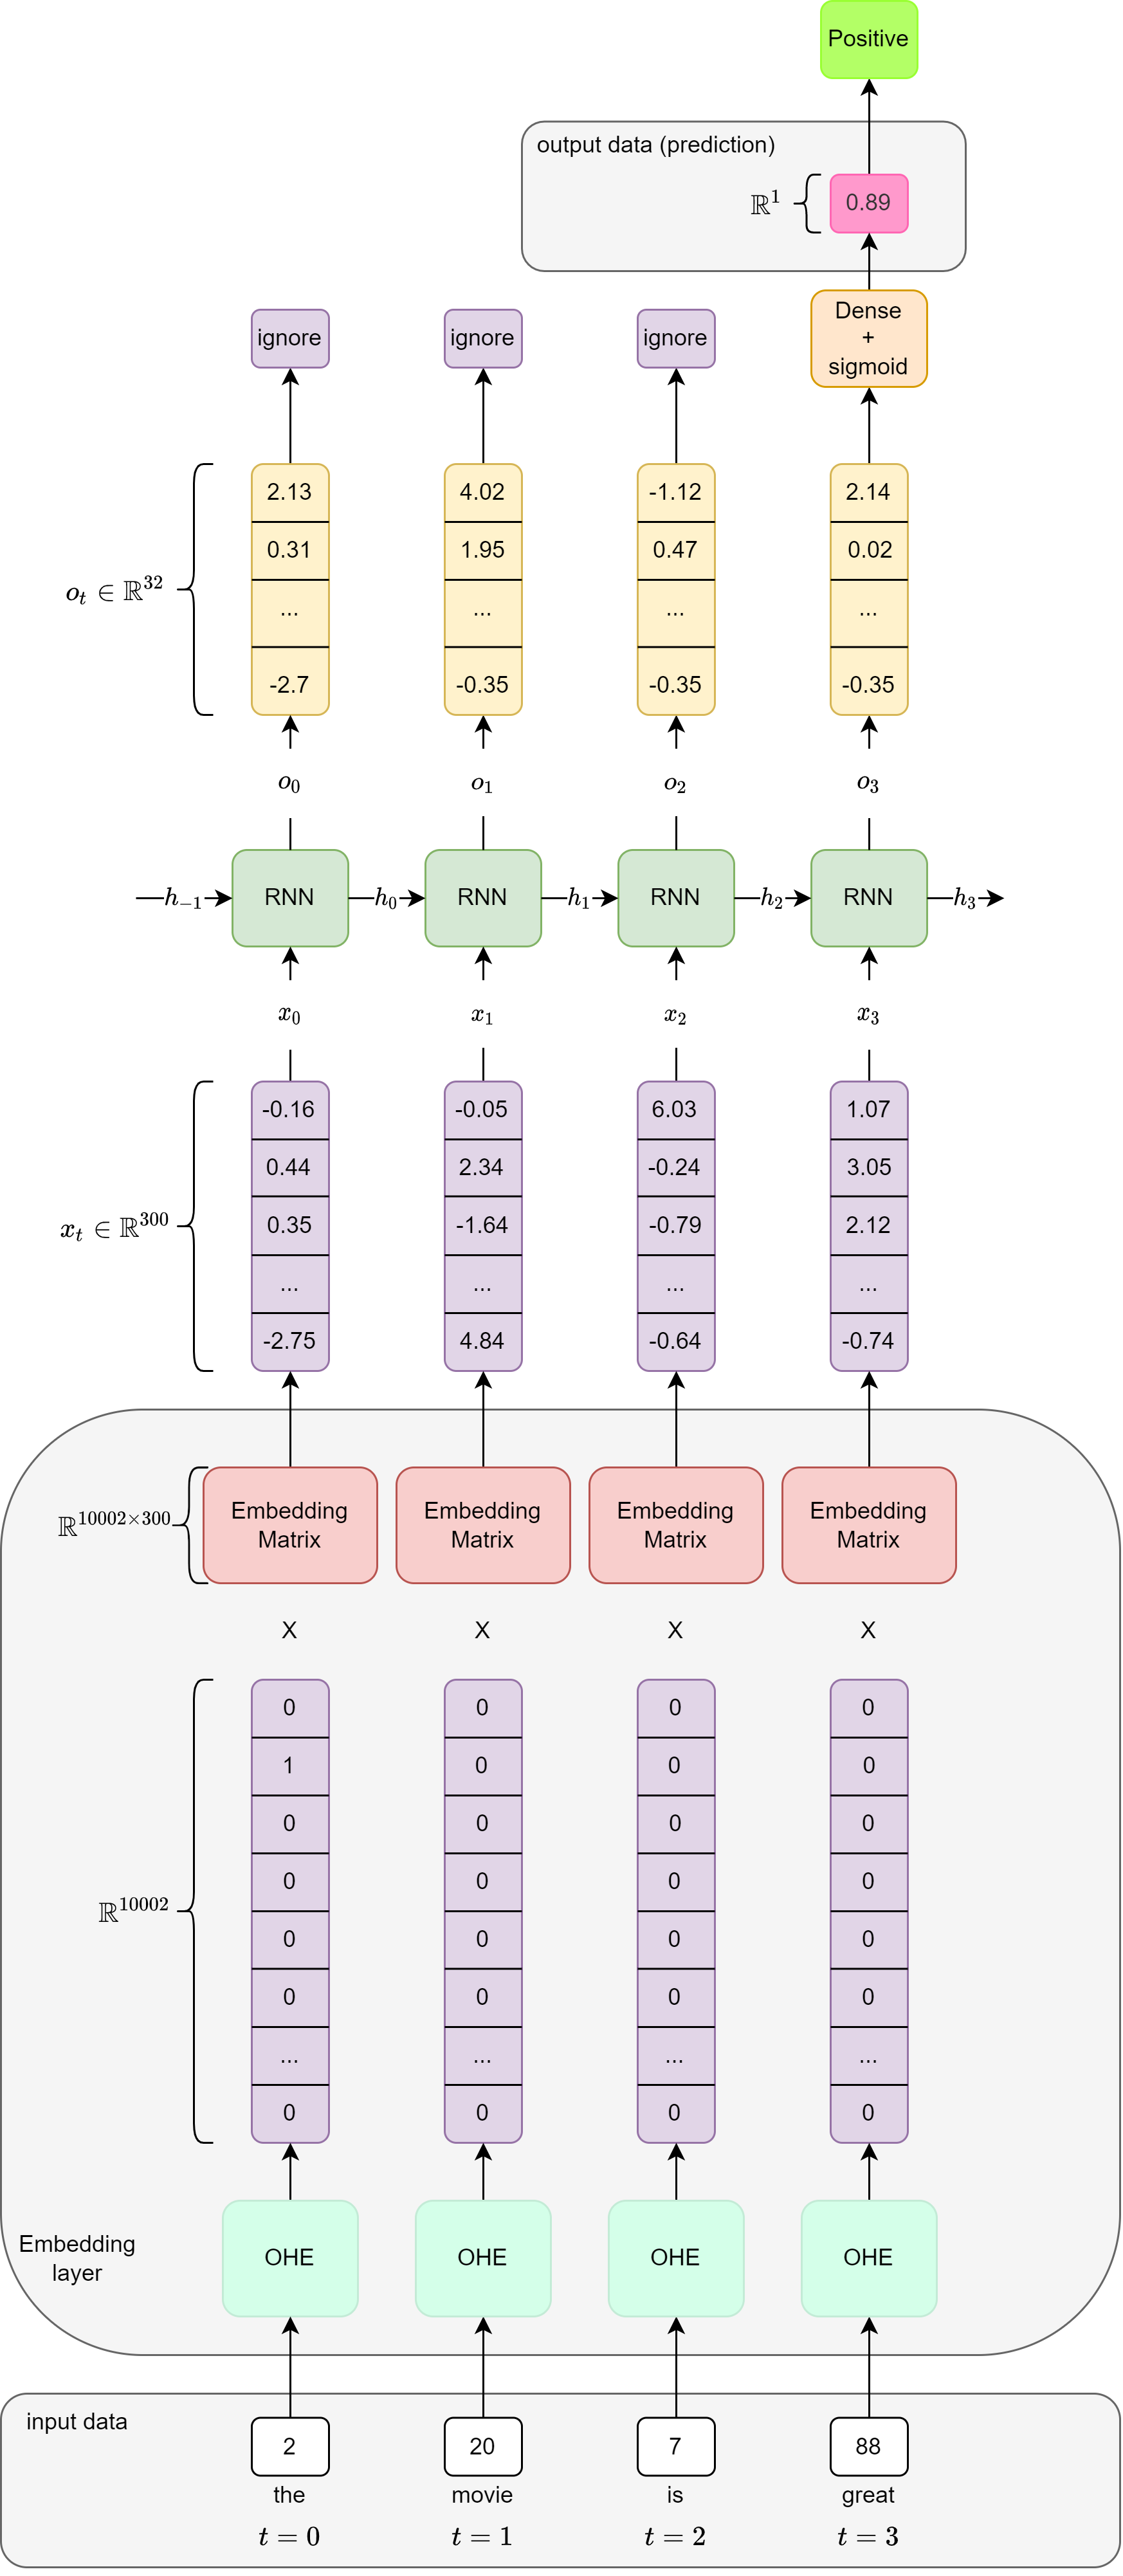"/>

The description of the architecture that we will use is as follows:

1. **Embedding layer**: It includes an Embedding Matrix that will output vector representations of each word of length N. This is a hyperparameter that can be tuned: in general if we constrain those vectors too much we will lose information but if we generate very long vectors we will not have any savings with respect to using directly the OHE vectors. General values for embedding layer outputs are between 100 and 300. In this case for the sake of the example we will use 5.

2. The input size of our embedding layer is the size of our vocabulary + 1, as the generated vocabulary is of size L but we need to include the integer $0$ that is in general reserved for padding.

3. We are going to use a **LSTM layer** instead of the SimpleRNN that we used before. In this case, as we want a many-to-one output, we are just interested in the last predicition (after all words have gone trough the model). Therefore we will set the `return_sequences` to `False` in order to ignore intermediate outputs.

4. We also need to define the shape of the LSTM output. In this case we have set an output of 5 (that is, for each step a vector with 5 elements will be generated).

5. And similar to the case of CNNs, since the shape of the final output is constrained by our problem (for example for a binary problem we are constrained to a single output between zero and one). We normally include a Dense layer (fully connected) with sigmoid activation at the very end. 

Once all of this is clear, we can define our problem and network in Keras

### 2.a. Many to one

In [7]:
# let's consider a very simple dataset of only two sentences that are already tokenized
sentence1 = ['I', 'am', 'a', 'Data', 'Scientist']
sentence2 = ['I', 'love', 'studying', 'Machine', 'Learning', 'and', 'Data', 'Analytics']

# each observation of our dataset is a sentence (a sequence of words)
train_data_mto = [sentence1, sentence2]

train_data_mto

[['I', 'am', 'a', 'Data', 'Scientist'],
 ['I', 'love', 'studying', 'Machine', 'Learning', 'and', 'Data', 'Analytics']]

In [8]:
# after cleaning the data and making it uniform (e.g., converting to lowercase, removing punctuation signs, etc)
## we would have the list of the vocabulary in our dataset
vocabulary_mto = ['i', 'am', 'a', 'data', 'scientist', 'love', 'studying', 'machine', 'learning', 'and', 'analytics']

In [9]:
# we assume that we already developed our data cleaning, tokenizing and converting to integers
## and that the dataset now looks like this:

# convert words to integers (using integers from 1 onwards, zero is typically reserved for padding)
sentence1_processed = [1, 2, 3, 4, 5]   # sequence 1 of length 5
sentence2_processed = [1, 6, 7, 8, 9, 10, 4, 11]   # sequence 2 of length 8

# we define a binary target arbitrarily (for example if it is related to whether I am talking about
## something that I like or something that I am
target_mto = [1, 0]

# pad all data to the length of the longest sentence
## here for the sake of the example it is done manually, but this can be done automatically
## finding how to do the whole text processing with Python is left as an exercise to the reader
sentence1_processed_padded = [ 0, 0, 0, 1, 2, 3, 4, 5]   # padded to the longest sentence (8 characters)
sentence2_processed_padded = [1, 6, 7, 8, 9, 10, 4, 11]


train_data_processed_padded_mto = [sentence1_processed_padded, sentence2_processed_padded]

train_data_processed_padded_mto

[[0, 0, 0, 1, 2, 3, 4, 5], [1, 6, 7, 8, 9, 10, 4, 11]]

In [10]:
# The input size of each observation (OHE) representation of each word
## is a vector with the total size of the vocabulary
## in this case 11 words
len(vocabulary_mto)

11

In [11]:
## Defining our model
myrnn_mto = keras.Sequential()

# Adding an embedding layer (that will convert our sequences of integer into OHE vectors and then 
## into a denser representation of smaller dimension by a matrix). The elements of this matrix are
## at the beginning randomly initialized then they are iterated during the training process

myrnn_mto.add(keras.layers.Embedding(input_dim=len(vocabulary_mto)+1,  # as usual in Keras, we need to specify the input dimension
                                                               # for the first layer (for the rest it will be automatically)
                                                               # calculated
                                 output_dim= 5,                # the size of the "denser" vector. In this case it is going to 
                                                               # convert each step from an input vector of length 11 to a 
                                                               # denser representation of length 5 (we have decided arbitrarily 
                                                               # the representation of 5. The output dimension is a 
                                                               # hyperparameter that can be iterated
                                 mask_zero=True))

myrnn_mto.add(keras.layers.LSTM(units=4,                          # Our LSTM will receive each step with an input of 5,
                                                               # will multiply by the corresponding weights (let's recall
                                                               # here that RNNs not only use the input but also information 
                                                               # from previous steps), and will return vectors of length four
                            return_sequences=False))           # In this case as, we are looking for a one-to-one problem we will
                                                               # not return the intermediate steps (although the reader is 
                                                               # encouraged to play with this parameter to get a sense of what
                                                               # a many-to-many problem would look like and how the outputs
                                                               # of the RNN look like

                
# Finally, we could add more layers to our model (e.g. a Dense layer if we are working with a binary classification problem)
myrnn_mto.add(keras.layers.Dense(units=1, 
                                 activation="sigmoid"))

As with other NNs, we can print the network summary with the shapes and params to learn

In [12]:
myrnn_mto.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 5)           60        
                                                                 
 lstm (LSTM)                 (None, 4)                 160       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


As with previous NNs, we compile the network, specifiying the loss function, optimizer and metrics to track

In [13]:
myrnn_mto.compile(loss= "binary_crossentropy", # loss for binary problems
              optimizer="adam",
              metrics=["accuracy"])

And we are ready to train the network, in this example we have trained our network with a batch size of two and three epochs

In [14]:
myrnn_mto.fit(x=train_data_processed_padded_mto,
              y=target_mto,
              batch_size=2,
              epochs=3)

Epoch 1/3
1/1 [==============================] - 2s 2s/step - loss: 0.6922 - accuracy: 0.5000
Epoch 2/3
1/1 [==============================] - 0s 16ms/step - loss: 0.6915 - accuracy: 1.0000
Epoch 3/3
1/1 [==============================] - 0s 20ms/step - loss: 0.6907 - accuracy: 1.0000


We can test our NN with unseen data

In [15]:
test_mto = ['i', 'am', 'a', 'scientist']
test_processed_padded_mto = [1, 2, 3, 5, 0, 0, 0, 0]   # same as with train data, we convert and pad with the same process
                                                   # note that the words representation and length is consistent with
                                                   # our train data, otherwise it cannot go through the network

In [16]:
# NNs work with vectors, so we convert our list to a numpy array
texts_tensor_mto = np.array([test_processed_padded_mto])
texts_tensor_mto

array([[1, 2, 3, 5, 0, 0, 0, 0]])

#### Generating predictions
We can generate the predictions using the predict method:

In [17]:
preds_mto = myrnn_mto.predict(texts_tensor_mto)
preds_mto

1/1 [==============================] - 2s 2s/step


array([[0.50126165]], dtype=float32)

###  2.b. Many to many
Let's consider the example in which we wanted to flag which words of a sentence are nouns or verbs. In this case, for each observation (each sentence) we need as many outputs as words in the sentence (i.e., the predicted classification of each word). This is an example of a many-to-many classification problem

In [18]:
# let's consider a very simple dataset of three sentences that are already tokenized
sentence1 = ['I', 'am', 'a', 'Data', 'Scientist']
sentence2 = ['I', 'love', 'studying', 'Machine', 'Learning', 'and', 'Data', 'Analytics']
sentence3 = ['Data', 'Science', 'is', 'fun']

# targets for each observation, which mean the type of word in the sentence:
## n for noun, v for verb, o for other word types
target_s1 = ['o', 'v', 'o', 'n', 'n']
target_s2 = ['o', 'v', 'v', 'n', 'n', 'o', 'n', 'n']
target_s3 = ['n', 'n', 'v', 'o']

# each observation of our dataset is a sentence (a sequence of words)
train_data_mtm = [sentence1, sentence2, sentence3]

train_data_mtm

[['I', 'am', 'a', 'Data', 'Scientist'],
 ['I', 'love', 'studying', 'Machine', 'Learning', 'and', 'Data', 'Analytics'],
 ['Data', 'Science', 'is', 'fun']]

Just for the reader's reference and as an example of the variables that we can have when preparing text data, we have left below some examples of the vocabulary (unique list of words) and the mapping between words and numbers for the input data and the target

In [19]:
vocabulary_mtm = ['i', 'am', 'a', 'data', 'scientist', 'love', 'studying', 'machine', 'learning', 'and', 'analytics', 'fun']

In [20]:
word_to_int = {'i': 1,
               'am': 2,
               'a' :3,
               'data': 4, 
               'scientist': 5,
               'love': 6,
               'studying': 7,
               'machine': 8,
               'learning' :9,
               'and': 10,
               'analytics': 11,
               'fun': 12}

target_to_int = {'o': 1, 'v': 2, 'n': 3}

As mentioned, the text processing has been done by brute force in this example (i.e., manually creating and applying the mappings), since this is not the goal of this example. 

However, below one can find the step-by-step process that should be followed and how the input data look like:

In [21]:
# we assume that we already developed our data cleaning, tokenizing and converting to integers
## and that the dataset now looks like this:

# convert words to integers (using integers from 1 onwards, zero is typically reserved for padding)
sentence1_processed = [1, 2, 3, 4, 5]              # sequence 1 of length 5
sentence2_processed = [1, 6, 7, 8, 9, 10, 4, 11]   # sequence 2 of length 8
sentence3_processed = [4, 5, 2, 12]   # sequence 3 of length 8


target_s1_processed = [1, 2, 1, 3, 3]
target_s2_processed = [1, 2, 2, 3, 3, 1, 3, 3]
target_s3_processed = [3, 3, 2, 1]

# pad all data to the length of the longest sentence (8 words in this case)
## here for the sake of the example it is done manually, but this can be done automatically
## finding how to do the whole text processing with Python is left as an exercise to the reader
sentence1_processed_padded = [0, 0, 0, 1, 2, 3, 4, 5]
sentence2_processed_padded = [1, 6, 7, 8, 9, 10, 4, 11]
sentence3_processed_padded = [0, 0, 0, 0, 4, 5, 2, 12]

target_s1_processed_padded = [0, 0, 0, 1, 2, 1, 3, 3]
target_s2_processed_padded = [1, 2, 2, 3, 3, 1, 3, 3]
target_s3_processed_padded = [0, 0, 0, 0, 3, 3, 2, 1]

train_data_processed_padded_mtm = [sentence1_processed_padded, sentence2_processed_padded, sentence3_processed_padded]
target_mtm = [target_s1_processed_padded, target_s2_processed_padded, target_s3_processed_padded]

print(train_data_processed_padded_mtm)

## questions: how is my target defined in this case? natural numbers or OHE?
## do we have a counter-embedding?
print(target_mtm)

[[0, 0, 0, 1, 2, 3, 4, 5], [1, 6, 7, 8, 9, 10, 4, 11], [0, 0, 0, 0, 4, 5, 2, 12]]
[[0, 0, 0, 1, 2, 1, 3, 3], [1, 2, 2, 3, 3, 1, 3, 3], [0, 0, 0, 0, 3, 3, 2, 1]]


In [22]:
print(train_data_processed_padded_mtm)

[[0, 0, 0, 1, 2, 3, 4, 5], [1, 6, 7, 8, 9, 10, 4, 11], [0, 0, 0, 0, 4, 5, 2, 12]]


#### Model definition

In [23]:
## Defining our model
myrnn_mtm = keras.Sequential()

# Adding an embedding layer (that will convert our sequences of integer into OHE vectors and then 
## into a denser representation of smaller dimension by a matrix). The elements of this matrix are
## at the beginning randomly initialized then they are iterated during the training process


# For a detailed explanation of the layers and their inputs see the "many-to-one" example above
myrnn_mtm.add(keras.layers.Embedding(input_dim=len(vocabulary_mtm)+1,
                                     input_length = 8,  # sequence length
                                     mask_zero=False, 
                                     output_dim = 7,
                                    ))

# As in the previous case, we will add a LSTM with an output of 5 units that we decide arbitrarily
myrnn_mtm.add(keras.layers.LSTM(units = 5,  
                                return_sequences=True))

# In this case we will add a Dense layer with four neurons (to be consistent with the shape)
## of our target variable
myrnn_mtm.add(keras.layers.Dense(units=4, 
                                 activation="sigmoid"))

In [24]:
myrnn_mtm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 8, 7)              91        
                                                                 
 lstm_1 (LSTM)               (None, 8, 5)              260       
                                                                 
 dense_1 (Dense)             (None, 8, 4)              24        
                                                                 
Total params: 375 (1.46 KB)
Trainable params: 375 (1.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We compile our model before training

In [25]:
myrnn_mtm.compile(loss= "sparse_categorical_crossentropy", # We use a more suitable loss function for categorical data, it 
                                                           ## already takes care of the OHE processing of our variable
                  optimizer="adam",
                  metrics=["accuracy"])

And we are ready to fit our data! The procedure is the same as with the rest of RNNs that we have seen so far in the course

In [26]:
myrnn_mtm.fit(x=train_data_processed_padded_mtm,
              y=target_mtm,
              batch_size=2,
              epochs=400)

Epoch 1/400
2/2 [==============================] - 3s 35ms/step - loss: 1.3844 - accuracy: 0.2917
Epoch 2/400
2/2 [==============================] - 0s 8ms/step - loss: 1.3822 - accuracy: 0.2500
Epoch 3/400
2/2 [==============================] - 0s 0s/step - loss: 1.3802 - accuracy: 0.3750
Epoch 4/400
2/2 [==============================] - 0s 16ms/step - loss: 1.3783 - accuracy: 0.3750
Epoch 5/400
2/2 [==============================] - 0s 9ms/step - loss: 1.3763 - accuracy: 0.6667
Epoch 6/400
2/2 [==============================] - 0s 15ms/step - loss: 1.3744 - accuracy: 0.6667
Epoch 7/400
2/2 [==============================] - 0s 9ms/step - loss: 1.3724 - accuracy: 0.6667
Epoch 8/400
2/2 [==============================] - 0s 12ms/step - loss: 1.3704 - accuracy: 0.6667
Epoch 9/400
2/2 [==============================] - 0s 6ms/step - loss: 1.3684 - accuracy: 0.6667
Epoch 10/400
2/2 [==============================] - 0s 16ms/step - loss: 1.3663 - accuracy: 0.6250
Epoch 11/400
2/2 [=======

2/2 [==============================] - 0s 14ms/step - loss: 1.0579 - accuracy: 0.6667
Epoch 85/400
2/2 [==============================] - 0s 16ms/step - loss: 1.0538 - accuracy: 0.6667
Epoch 86/400
2/2 [==============================] - 0s 31ms/step - loss: 1.0498 - accuracy: 0.6667
Epoch 87/400
2/2 [==============================] - 0s 4ms/step - loss: 1.0457 - accuracy: 0.6667
Epoch 88/400
2/2 [==============================] - 0s 16ms/step - loss: 1.0416 - accuracy: 0.6667
Epoch 89/400
2/2 [==============================] - 0s 10ms/step - loss: 1.0375 - accuracy: 0.6667
Epoch 90/400
2/2 [==============================] - 0s 11ms/step - loss: 1.0335 - accuracy: 0.6667
Epoch 91/400
2/2 [==============================] - 0s 14ms/step - loss: 1.0294 - accuracy: 0.6667
Epoch 92/400
2/2 [==============================] - 0s 23ms/step - loss: 1.0253 - accuracy: 0.6667
Epoch 93/400
2/2 [==============================] - 0s 17ms/step - loss: 1.0213 - accuracy: 0.6667
Epoch 94/400
2/2 [======

2/2 [==============================] - 0s 13ms/step - loss: 0.7437 - accuracy: 0.8333
Epoch 167/400
2/2 [==============================] - 0s 7ms/step - loss: 0.7400 - accuracy: 0.8333
Epoch 168/400
2/2 [==============================] - 0s 13ms/step - loss: 0.7362 - accuracy: 0.8333
Epoch 169/400
2/2 [==============================] - 0s 14ms/step - loss: 0.7324 - accuracy: 0.8333
Epoch 170/400
2/2 [==============================] - 0s 12ms/step - loss: 0.7286 - accuracy: 0.8333
Epoch 171/400
2/2 [==============================] - 0s 13ms/step - loss: 0.7248 - accuracy: 0.8333
Epoch 172/400
2/2 [==============================] - 0s 14ms/step - loss: 0.7209 - accuracy: 0.8333
Epoch 173/400
2/2 [==============================] - 0s 10ms/step - loss: 0.7171 - accuracy: 0.8333
Epoch 174/400
2/2 [==============================] - 0s 6ms/step - loss: 0.7132 - accuracy: 0.8333
Epoch 175/400
2/2 [==============================] - 0s 11ms/step - loss: 0.7094 - accuracy: 0.8333
Epoch 176/400
2/

2/2 [==============================] - 0s 13ms/step - loss: 0.4080 - accuracy: 1.0000
Epoch 249/400
2/2 [==============================] - 0s 9ms/step - loss: 0.4043 - accuracy: 1.0000
Epoch 250/400
2/2 [==============================] - 0s 4ms/step - loss: 0.4005 - accuracy: 1.0000
Epoch 251/400
2/2 [==============================] - 0s 17ms/step - loss: 0.3968 - accuracy: 1.0000
Epoch 252/400
2/2 [==============================] - 0s 21ms/step - loss: 0.3932 - accuracy: 1.0000
Epoch 253/400
2/2 [==============================] - 0s 8ms/step - loss: 0.3895 - accuracy: 1.0000
Epoch 254/400
2/2 [==============================] - 0s 8ms/step - loss: 0.3859 - accuracy: 1.0000
Epoch 255/400
2/2 [==============================] - 0s 0s/step - loss: 0.3823 - accuracy: 1.0000
Epoch 256/400
2/2 [==============================] - 0s 3ms/step - loss: 0.3788 - accuracy: 1.0000
Epoch 257/400
2/2 [==============================] - 0s 6ms/step - loss: 0.3752 - accuracy: 1.0000
Epoch 258/400
2/2 [===

2/2 [==============================] - 0s 0s/step - loss: 0.1956 - accuracy: 1.0000
Epoch 331/400
2/2 [==============================] - 0s 0s/step - loss: 0.1940 - accuracy: 1.0000
Epoch 332/400
2/2 [==============================] - 0s 0s/step - loss: 0.1924 - accuracy: 1.0000
Epoch 333/400
2/2 [==============================] - 0s 9ms/step - loss: 0.1909 - accuracy: 1.0000
Epoch 334/400
2/2 [==============================] - 0s 11ms/step - loss: 0.1894 - accuracy: 1.0000
Epoch 335/400
2/2 [==============================] - 0s 0s/step - loss: 0.1879 - accuracy: 1.0000
Epoch 336/400
2/2 [==============================] - 0s 4ms/step - loss: 0.1864 - accuracy: 1.0000
Epoch 337/400
2/2 [==============================] - 0s 16ms/step - loss: 0.1849 - accuracy: 1.0000
Epoch 338/400
2/2 [==============================] - 0s 13ms/step - loss: 0.1834 - accuracy: 1.0000
Epoch 339/400
2/2 [==============================] - 0s 7ms/step - loss: 0.1820 - accuracy: 1.0000
Epoch 340/400
2/2 [======

#### Generating predictions
Let's try to predict the sentence "I love studying data", for which the target would be "o, v, v, n": 1, 2, 2, 3 and four zeros for padding

In [30]:
# We would need to tokenize and pad our data following the process that we have carried out with our train data
test_mtm = np.array([[0, 0, 0, 0, 1, 6, 7, 4]])

In [31]:
# Once we have done that we can apply our trained model to predict the output (a vector of 4 elements)
## with the probability of belonging to each of the classes defined (0 for padded data, 1 for any word that
## is not a noun or verb, 2 for a verb, 3 for a noun)
prediction_mtm = myrnn_mtm.predict(test_mtm)

prediction_mtm

1/1 [==============================] - 0s 31ms/step


array([[[0.90124935, 0.42622864, 0.52359146, 0.05536856],
        [0.93456334, 0.43148088, 0.5281951 , 0.03074948],
        [0.9395222 , 0.4460466 , 0.5295481 , 0.02628666],
        [0.9399365 , 0.450781  , 0.53662694, 0.02510867],
        [0.41380033, 0.88230246, 0.33401203, 0.31851807],
        [0.46947175, 0.20093906, 0.9171684 , 0.35209385],
        [0.34101254, 0.1762108 , 0.939923  , 0.48729   ],
        [0.03109746, 0.28471613, 0.74761   , 0.98971385]]], dtype=float32)

In [32]:
# We can assign each word to a class by getting the class with the highest probability,
## in this case we will do it for the first (and only) entry in our dataset
[np.argmax(element) for element in prediction_mtm[0]]

[0, 0, 0, 0, 1, 2, 2, 3]